In [32]:
import numpy as np
import tensorflow as tf
import gzip
import pickle
import sys
import copy
import os.path
import pdb
import re
from ddm.run_split import SplitMnistGenerator
from ddm.run_not import NotMnistGenerator
from ddm.alg.cla_models_multihead import MFVI_IBP_NN, Vanilla_NN
from ddm.alg.utils import get_scores, concatenate_results
from ddm.alg.vcl import run_vcl
from copy import deepcopy

from bayes_opt import BayesianOptimization

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Split MNIST

In [54]:
hidden_size = [100]
batch_size = 128
no_epochs = 500
alpha0 = 5.0
tau0=1.0 # initial temperature
ANNEAL_RATE=0.000
MIN_TEMP=0.1
ibp_samples = 10
learning_rate=0.0001

# Run vanilla VCL
tf.set_random_seed(12)
np.random.seed(1)

ibp_acc = np.array([])

coreset_size = 0
val = True
data_gen = SplitMnistGenerator(val)
single_head=False
in_dim, out_dim = data_gen.get_dims()
x_testsets, y_testsets = [], []
x_valsets, y_valsets = [], []
for task_id in range(data_gen.max_iter):
    
    tf.reset_default_graph()
    if val:
        x_train, y_train, x_test, y_test, x_val, y_val = data_gen.next_task()
        x_valsets.append(x_val)
        y_valsets.append(y_val)
    else:    
        x_train, y_train, x_test, y_test = data_gen.next_task()
    x_testsets.append(x_test)
    y_testsets.append(y_test)

    # Set the readout head to train
    head = 0 if single_head else task_id
    bsize = x_train.shape[0] if (batch_size is None) else batch_size
    
    # Train network with maximum likelihood to initialize first model
    if task_id == 0:
        ml_model = Vanilla_NN(in_dim, hidden_size, out_dim, x_train.shape[0])
        ml_model.train(x_train, y_train, task_id, no_epochs, bsize)
        mf_weights = ml_model.get_weights()
        mf_variances = None
        mf_betas = None
        ml_model.close_session()

    # Train on non-coreset data
    mf_model = MFVI_IBP_NN(in_dim, hidden_size, out_dim, x_train.shape[0], num_ibp_samples=ibp_samples,
                           prev_means=mf_weights, 
                           prev_log_variances=mf_variances, prev_betas=mf_betas,alpha0=alpha0,
                           learning_rate=learning_rate, lambda_1=tau0, lambda_2=1.0, no_pred_samples=100,
                          name='ibp_split')
    mf_model.train(x_train, y_train, head, no_epochs, bsize,
                   anneal_rate=ANNEAL_RATE, min_temp=MIN_TEMP)
    mf_weights, mf_variances, mf_betas = mf_model.get_weights()

    acc = get_scores(mf_model, x_valsets, y_valsets, single_head)
    ibp_acc = concatenate_results(acc, ibp_acc)
    
    mf_model.close_session()
    
ibp_acc

Epoch: 0001 cost= 0.060810656
Epoch: 0006 cost= 0.001113781
Epoch: 0011 cost= 0.000229901
Epoch: 0016 cost= 0.000094831
Epoch: 0021 cost= 0.000052008
Epoch: 0026 cost= 0.000031261
Epoch: 0031 cost= 0.000020183
Epoch: 0036 cost= 0.000013382
Epoch: 0041 cost= 0.000009496
Epoch: 0046 cost= 0.000006787
Epoch: 0051 cost= 0.000004937
Epoch: 0056 cost= 0.000003700
Epoch: 0061 cost= 0.000002791
Epoch: 0066 cost= 0.000002138
Epoch: 0071 cost= 0.000001654
Epoch: 0076 cost= 0.000001258
Epoch: 0081 cost= 0.000000993
Epoch: 0086 cost= 0.000000762
Epoch: 0091 cost= 0.000000596
Epoch: 0096 cost= 0.000000465
Epoch: 0101 cost= 0.000000362
Epoch: 0106 cost= 0.000000289
Epoch: 0111 cost= 0.000000225
Epoch: 0116 cost= 0.000000180
Epoch: 0121 cost= 0.000000140
Epoch: 0126 cost= 0.000000111
Epoch: 0131 cost= 0.000000087
Epoch: 0136 cost= 0.000000069
Epoch: 0141 cost= 0.000000056
Epoch: 0146 cost= 0.000000044
Epoch: 0151 cost= 0.000000035
Epoch: 0156 cost= 0.000000028
Epoch: 0161 cost= 0.000000022
Epoch: 016

Epoch: 0186 train cost= 0.607791376
Epoch: 0191 train cost= 0.606797076
Epoch: 0196 train cost= 0.604921242
Epoch: 0201 train cost= 0.604336350
Epoch: 0206 train cost= 0.605607834
Epoch: 0211 train cost= 0.598934251
Epoch: 0216 train cost= 0.601873489
Epoch: 0221 train cost= 0.597087183
Epoch: 0226 train cost= 0.595378202
Epoch: 0231 train cost= 0.594431960
Epoch: 0236 train cost= 0.591092754
Epoch: 0241 train cost= 0.591482836
Epoch: 0246 train cost= 0.588397314
Epoch: 0251 train cost= 0.591404824
Epoch: 0256 train cost= 0.585769880
Epoch: 0261 train cost= 0.586446656
Epoch: 0266 train cost= 0.586779819
Epoch: 0271 train cost= 0.582336948
Epoch: 0276 train cost= 0.583257229
Epoch: 0281 train cost= 0.581791551
Epoch: 0286 train cost= 0.581267452
Epoch: 0291 train cost= 0.581240634
Epoch: 0296 train cost= 0.579008404
Epoch: 0301 train cost= 0.580591082
Epoch: 0306 train cost= 0.579313078
Epoch: 0311 train cost= 0.574320959
Epoch: 0316 train cost= 0.574787986
Epoch: 0321 train cost= 0.57

Epoch: 0296 train cost= 0.299683349
Epoch: 0301 train cost= 0.300341254
Epoch: 0306 train cost= 0.299823100
Epoch: 0311 train cost= 0.298617943
Epoch: 0316 train cost= 0.298525424
Epoch: 0321 train cost= 0.297153664
Epoch: 0326 train cost= 0.298211516
Epoch: 0331 train cost= 0.296171424
Epoch: 0336 train cost= 0.296001111
Epoch: 0341 train cost= 0.294881415
Epoch: 0346 train cost= 0.293889106
Epoch: 0351 train cost= 0.294590280
Epoch: 0356 train cost= 0.295295795
Epoch: 0361 train cost= 0.293123007
Epoch: 0366 train cost= 0.290582712
Epoch: 0371 train cost= 0.291670363
Epoch: 0376 train cost= 0.291683392
Epoch: 0381 train cost= 0.293125673
Epoch: 0386 train cost= 0.288820515
Epoch: 0391 train cost= 0.290783371
Epoch: 0396 train cost= 0.290023343
Epoch: 0401 train cost= 0.290169884
Epoch: 0406 train cost= 0.286974927
Epoch: 0411 train cost= 0.288034623
Epoch: 0416 train cost= 0.288313990
Epoch: 0421 train cost= 0.285717923
Epoch: 0426 train cost= 0.286228533
Epoch: 0431 train cost= 0.28

array([[0.99902676,        nan,        nan,        nan,        nan],
       [0.9946472 , 0.98514851,        nan,        nan,        nan],
       [0.91678832, 0.95049505, 0.98893572,        nan,        nan],
       [0.82043796, 0.94158416, 0.97945205, 0.99951386,        nan],
       [0.7863747 , 0.74108911, 0.94889357, 0.98152649, 0.98172589]])

In [41]:
# Run Vanilla VCL
tf.reset_default_graph()
tf.set_random_seed(12)
np.random.seed(1)
hidden_size = [10]
coreset_size = 0

data_gen = SplitMnistGenerator(val=True)
vcl_result_h10 = run_vcl(hidden_size, no_epochs, data_gen, 
                              lambda a: a, coreset_size, batch_size, single_head, val=True)
print(vcl_result_h10)

Epoch: 0001 cost= 0.260041745
Epoch: 0006 cost= 0.005151312
Epoch: 0011 cost= 0.002609195
Epoch: 0016 cost= 0.001677913
Epoch: 0021 cost= 0.001073658
Epoch: 0026 cost= 0.000651595
Epoch: 0031 cost= 0.000435936
Epoch: 0036 cost= 0.000280965
Epoch: 0041 cost= 0.000201473
Epoch: 0046 cost= 0.000137499
Epoch: 0051 cost= 0.000096778
Epoch: 0056 cost= 0.000071720
Epoch: 0061 cost= 0.000053018
Epoch: 0066 cost= 0.000040704
Epoch: 0071 cost= 0.000031381
Epoch: 0076 cost= 0.000023424
Epoch: 0081 cost= 0.000018736
Epoch: 0086 cost= 0.000013911
Epoch: 0091 cost= 0.000010898
Epoch: 0096 cost= 0.000008418
Epoch: 0101 cost= 0.000006566
Epoch: 0106 cost= 0.000005216
Epoch: 0111 cost= 0.000004077
Epoch: 0116 cost= 0.000003294
Epoch: 0121 cost= 0.000002540
Epoch: 0126 cost= 0.000002001
Epoch: 0131 cost= 0.000001540
Epoch: 0136 cost= 0.000001230
Epoch: 0141 cost= 0.000001004
Epoch: 0146 cost= 0.000000796
Epoch: 0151 cost= 0.000000621
Epoch: 0156 cost= 0.000000498
Epoch: 0161 cost= 0.000000388
Epoch: 016

Epoch: 0361 cost= 0.112424998
Epoch: 0366 cost= 0.112599989
Epoch: 0371 cost= 0.114160033
Epoch: 0376 cost= 0.111334790
Epoch: 0381 cost= 0.112474910
Epoch: 0386 cost= 0.110979694
Epoch: 0391 cost= 0.112247912
Epoch: 0396 cost= 0.112363790
Epoch: 0401 cost= 0.110589483
Epoch: 0406 cost= 0.112540329
Epoch: 0411 cost= 0.111491006
Epoch: 0416 cost= 0.112058918
Epoch: 0421 cost= 0.112748483
Epoch: 0426 cost= 0.111871792
Epoch: 0431 cost= 0.110491695
Epoch: 0436 cost= 0.111407667
Epoch: 0441 cost= 0.110001673
Epoch: 0446 cost= 0.111410917
Epoch: 0451 cost= 0.111964901
Epoch: 0456 cost= 0.112263441
Epoch: 0461 cost= 0.110262892
Epoch: 0466 cost= 0.110891941
Epoch: 0471 cost= 0.113165151
Epoch: 0476 cost= 0.111049803
Epoch: 0481 cost= 0.110088113
Epoch: 0486 cost= 0.110591270
Epoch: 0491 cost= 0.111587735
Epoch: 0496 cost= 0.108553015
Optimization Finished!
Epoch: 0001 cost= 1.747720936
Epoch: 0006 cost= 0.240851233
Epoch: 0011 cost= 0.143021355
Epoch: 0016 cost= 0.112361752
Epoch: 0021 cost=

Epoch: 0216 cost= 0.078199471
Epoch: 0221 cost= 0.077651928
Epoch: 0226 cost= 0.076728973
Epoch: 0231 cost= 0.077014558
Epoch: 0236 cost= 0.077256565
Epoch: 0241 cost= 0.077550059
Epoch: 0246 cost= 0.077167033
Epoch: 0251 cost= 0.078058227
Epoch: 0256 cost= 0.077440740
Epoch: 0261 cost= 0.076801294
Epoch: 0266 cost= 0.077735109
Epoch: 0271 cost= 0.078328427
Epoch: 0276 cost= 0.076528851
Epoch: 0281 cost= 0.078254801
Epoch: 0286 cost= 0.076451463
Epoch: 0291 cost= 0.077790918
Epoch: 0296 cost= 0.077668240
Epoch: 0301 cost= 0.078340689
Epoch: 0306 cost= 0.077726849
Epoch: 0311 cost= 0.076585741
Epoch: 0316 cost= 0.077083280
Epoch: 0321 cost= 0.077921762
Epoch: 0326 cost= 0.077061642
Epoch: 0331 cost= 0.077081200
Epoch: 0336 cost= 0.076471400
Epoch: 0341 cost= 0.075822363
Epoch: 0346 cost= 0.078528342
Epoch: 0351 cost= 0.075820650
Epoch: 0356 cost= 0.078251954
Epoch: 0361 cost= 0.076400601
Epoch: 0366 cost= 0.075716791
Epoch: 0371 cost= 0.077542798
Epoch: 0376 cost= 0.078248538
Epoch: 038

In [35]:
# Run Vanilla VCL
tf.reset_default_graph()
tf.set_random_seed(12)
np.random.seed(1)
hidden_size = [5]
coreset_size = 0

data_gen = SplitMnistGenerator(val=True)
vcl_result_h5 = run_vcl(hidden_size, no_epochs, data_gen, 
                              lambda a: a, coreset_size, batch_size, single_head, val=True)
print(vcl_result_h5)

Epoch: 0001 cost= 0.309737705
Epoch: 0006 cost= 0.006505377
Epoch: 0011 cost= 0.003437584
Epoch: 0016 cost= 0.002382604
Epoch: 0021 cost= 0.001687482
Epoch: 0026 cost= 0.001214309
Epoch: 0031 cost= 0.000888697
Epoch: 0036 cost= 0.000603936
Epoch: 0041 cost= 0.000437614
Epoch: 0046 cost= 0.000311826
Epoch: 0051 cost= 0.000223115
Epoch: 0056 cost= 0.000166145
Epoch: 0061 cost= 0.000123753
Epoch: 0066 cost= 0.000096306
Epoch: 0071 cost= 0.000074502
Epoch: 0076 cost= 0.000055685
Epoch: 0081 cost= 0.000045240
Epoch: 0086 cost= 0.000033811
Epoch: 0091 cost= 0.000026492
Epoch: 0096 cost= 0.000020607
Epoch: 0101 cost= 0.000016053
Epoch: 0106 cost= 0.000012792
Epoch: 0111 cost= 0.000010045
Epoch: 0116 cost= 0.000008124
Epoch: 0121 cost= 0.000006303
Epoch: 0126 cost= 0.000004970
Epoch: 0131 cost= 0.000003808
Epoch: 0136 cost= 0.000003043
Epoch: 0141 cost= 0.000002500
Epoch: 0146 cost= 0.000001978
Epoch: 0151 cost= 0.000001547
Epoch: 0156 cost= 0.000001240
Epoch: 0161 cost= 0.000000966
Epoch: 016

Epoch: 0361 cost= 0.108858067
Epoch: 0366 cost= 0.109106213
Epoch: 0371 cost= 0.110991352
Epoch: 0376 cost= 0.109299927
Epoch: 0381 cost= 0.109381017
Epoch: 0386 cost= 0.110753206
Epoch: 0391 cost= 0.110726504
Epoch: 0396 cost= 0.110525607
Epoch: 0401 cost= 0.109461984
Epoch: 0406 cost= 0.110348284
Epoch: 0411 cost= 0.109574614
Epoch: 0416 cost= 0.109322671
Epoch: 0421 cost= 0.109838757
Epoch: 0426 cost= 0.108975247
Epoch: 0431 cost= 0.111462446
Epoch: 0436 cost= 0.109412228
Epoch: 0441 cost= 0.109360211
Epoch: 0446 cost= 0.108407914
Epoch: 0451 cost= 0.109430509
Epoch: 0456 cost= 0.111374630
Epoch: 0461 cost= 0.109166542
Epoch: 0466 cost= 0.109687193
Epoch: 0471 cost= 0.109564376
Epoch: 0476 cost= 0.109749161
Epoch: 0481 cost= 0.111493934
Epoch: 0486 cost= 0.109688347
Epoch: 0491 cost= 0.110477972
Epoch: 0496 cost= 0.109936242
Optimization Finished!
Epoch: 0001 cost= 0.991630912
Epoch: 0006 cost= 0.305215159
Epoch: 0011 cost= 0.185663481
Epoch: 0016 cost= 0.124416986
Epoch: 0021 cost=

Epoch: 0216 cost= 0.073933782
Epoch: 0221 cost= 0.071977028
Epoch: 0226 cost= 0.073328345
Epoch: 0231 cost= 0.072604141
Epoch: 0236 cost= 0.072117073
Epoch: 0241 cost= 0.073661257
Epoch: 0246 cost= 0.074492393
Epoch: 0251 cost= 0.072487670
Epoch: 0256 cost= 0.072265544
Epoch: 0261 cost= 0.072808026
Epoch: 0266 cost= 0.073659471
Epoch: 0271 cost= 0.072949984
Epoch: 0276 cost= 0.073966805
Epoch: 0281 cost= 0.071343466
Epoch: 0286 cost= 0.072327455
Epoch: 0291 cost= 0.072778051
Epoch: 0296 cost= 0.073326177
Epoch: 0301 cost= 0.071940059
Epoch: 0306 cost= 0.073695143
Epoch: 0311 cost= 0.072274628
Epoch: 0316 cost= 0.071968447
Epoch: 0321 cost= 0.073160590
Epoch: 0326 cost= 0.072694900
Epoch: 0331 cost= 0.073583660
Epoch: 0336 cost= 0.072782677
Epoch: 0341 cost= 0.072901333
Epoch: 0346 cost= 0.073508694
Epoch: 0351 cost= 0.072219688
Epoch: 0356 cost= 0.072881953
Epoch: 0361 cost= 0.072751624
Epoch: 0366 cost= 0.072884918
Epoch: 0371 cost= 0.073379194
Epoch: 0376 cost= 0.072142537
Epoch: 038

In [36]:
# Run Vanilla VCL
tf.reset_default_graph()
tf.set_random_seed(12)
np.random.seed(1)
hidden_size = [50]
coreset_size = 0

data_gen = SplitMnistGenerator(val=True)
vcl_result_h50 = run_vcl(hidden_size, no_epochs, data_gen, 
                              lambda a: a, coreset_size, batch_size, single_head, val=True)
print(vcl_result_h50)

Epoch: 0001 cost= 0.079691100
Epoch: 0006 cost= 0.001804116
Epoch: 0011 cost= 0.000520605
Epoch: 0016 cost= 0.000217507
Epoch: 0021 cost= 0.000119775
Epoch: 0026 cost= 0.000072325
Epoch: 0031 cost= 0.000046878
Epoch: 0036 cost= 0.000030816
Epoch: 0041 cost= 0.000022064
Epoch: 0046 cost= 0.000015821
Epoch: 0051 cost= 0.000011496
Epoch: 0056 cost= 0.000008699
Epoch: 0061 cost= 0.000006534
Epoch: 0066 cost= 0.000005036
Epoch: 0071 cost= 0.000003924
Epoch: 0076 cost= 0.000002973
Epoch: 0081 cost= 0.000002341
Epoch: 0086 cost= 0.000001823
Epoch: 0091 cost= 0.000001423
Epoch: 0096 cost= 0.000001126
Epoch: 0101 cost= 0.000000870
Epoch: 0106 cost= 0.000000692
Epoch: 0111 cost= 0.000000542
Epoch: 0116 cost= 0.000000434
Epoch: 0121 cost= 0.000000341
Epoch: 0126 cost= 0.000000268
Epoch: 0131 cost= 0.000000209
Epoch: 0136 cost= 0.000000166
Epoch: 0141 cost= 0.000000135
Epoch: 0146 cost= 0.000000106
Epoch: 0151 cost= 0.000000083
Epoch: 0156 cost= 0.000000068
Epoch: 0161 cost= 0.000000054
Epoch: 016

Epoch: 0361 cost= 0.137728411
Epoch: 0366 cost= 0.136152509
Epoch: 0371 cost= 0.135047906
Epoch: 0376 cost= 0.134208464
Epoch: 0381 cost= 0.137106485
Epoch: 0386 cost= 0.137147681
Epoch: 0391 cost= 0.135499875
Epoch: 0396 cost= 0.135304051
Epoch: 0401 cost= 0.136566447
Epoch: 0406 cost= 0.136051203
Epoch: 0411 cost= 0.133930418
Epoch: 0416 cost= 0.136314917
Epoch: 0421 cost= 0.137140079
Epoch: 0426 cost= 0.136358528
Epoch: 0431 cost= 0.136754363
Epoch: 0436 cost= 0.136682447
Epoch: 0441 cost= 0.136173004
Epoch: 0446 cost= 0.134194762
Epoch: 0451 cost= 0.135076017
Epoch: 0456 cost= 0.136936297
Epoch: 0461 cost= 0.134516468
Epoch: 0466 cost= 0.134700422
Epoch: 0471 cost= 0.135558381
Epoch: 0476 cost= 0.135787606
Epoch: 0481 cost= 0.135386662
Epoch: 0486 cost= 0.135895842
Epoch: 0491 cost= 0.136754206
Epoch: 0496 cost= 0.135471402
Optimization Finished!
Epoch: 0001 cost= 1.980342969
Epoch: 0006 cost= 0.250488613
Epoch: 0011 cost= 0.163267189
Epoch: 0016 cost= 0.138874707
Epoch: 0021 cost=

Epoch: 0216 cost= 0.080769287
Epoch: 0221 cost= 0.079403157
Epoch: 0226 cost= 0.079974648
Epoch: 0231 cost= 0.081229776
Epoch: 0236 cost= 0.080865486
Epoch: 0241 cost= 0.080967901
Epoch: 0246 cost= 0.079758412
Epoch: 0251 cost= 0.080099691
Epoch: 0256 cost= 0.080946358
Epoch: 0261 cost= 0.080334794
Epoch: 0266 cost= 0.082161283
Epoch: 0271 cost= 0.081122922
Epoch: 0276 cost= 0.081836150
Epoch: 0281 cost= 0.081300376
Epoch: 0286 cost= 0.080235807
Epoch: 0291 cost= 0.079911790
Epoch: 0296 cost= 0.081338176
Epoch: 0301 cost= 0.079497364
Epoch: 0306 cost= 0.081222769
Epoch: 0311 cost= 0.079541663
Epoch: 0316 cost= 0.080674942
Epoch: 0321 cost= 0.078639953
Epoch: 0326 cost= 0.080303361
Epoch: 0331 cost= 0.081783515
Epoch: 0336 cost= 0.080259208
Epoch: 0341 cost= 0.080652494
Epoch: 0346 cost= 0.080888671
Epoch: 0351 cost= 0.079786365
Epoch: 0356 cost= 0.079431171
Epoch: 0361 cost= 0.081401853
Epoch: 0366 cost= 0.079107091
Epoch: 0371 cost= 0.081411318
Epoch: 0376 cost= 0.080227670
Epoch: 038

In [47]:
_ibp_acc = np.nanmean(ibp_acc, 1) # each row is averaged!
_vcl_result_h10 = np.nanmean(vcl_result, 1)
_vcl_result_h5 = np.nanmean(vcl_result_h5, 1)
_vcl_result_h50 = np.nanmean(vcl_result_h50, 1)

/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


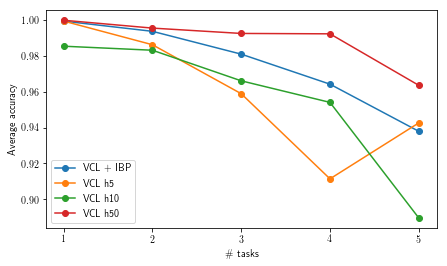

In [55]:
fig = plt.figure(figsize=(7,4))
ax = plt.gca()
plt.plot(np.arange(len(_ibp_acc))+1, _ibp_acc, label='VCL + IBP', marker='o')
plt.plot(np.arange(len(_ibp_acc))+1, _vcl_result_h5, label='VCL h5', marker='o')
plt.plot(np.arange(len(_ibp_acc))+1, _vcl_result_h10, label='VCL h10', marker='o')
plt.plot(np.arange(len(_ibp_acc))+1, _vcl_result_h50, label='VCL h50', marker='o')
ax.set_xticks(range(1, len(_ibp_acc)+1))
ax.set_ylabel('Average accuracy')
ax.set_xlabel('\# tasks')
ax.legend()
fig.show()

In [56]:
with open('results/split_mnist.pkl', 'wb') as input_file:
    pickle.dump({'vcl_ibp': ibp_acc,
                 'vcl_h10': vcl_result,
                 'vcl_h5': vcl_result_h5,
                 'vcl_h50': vcl_result_h50}, input_file)

# Not MNIST

In [57]:
hidden_size = [100]
batch_size = 128
no_epochs = 500
ibp_samples = 10
learning_rate=0.0001

# Run vanilla VCL
tf.set_random_seed(12)
np.random.seed(1)

ibp_acc = np.array([])

coreset_size = 0
data_gen = NotMnistGenerator()
single_head=False
in_dim, out_dim = data_gen.get_dims()
x_testsets, y_testsets = [], []
#x_valsets, y_valsets = [], []
for task_id in range(data_gen.max_iter):
    
    tf.reset_default_graph()
    x_train, y_train, x_test, y_test, _, _ = data_gen.next_task()
    #x_valsets.append(x_val)
    #y_valsets.append(y_val)
    x_testsets.append(x_test)
    y_testsets.append(y_test)

    # Set the readout head to train
    head = 0 if single_head else task_id
    bsize = x_train.shape[0] if (batch_size is None) else batch_size
    
    # Train network with maximum likelihood to initialize first model
    if task_id == 0:
        ml_model = Vanilla_NN(in_dim, hidden_size, out_dim, x_train.shape[0])
        ml_model.train(x_train, y_train, task_id, no_epochs, bsize)
        mf_weights = ml_model.get_weights()
        mf_variances = None
        mf_betas = None
        ml_model.close_session()

    # Train on non-coreset data
    mf_model = MFVI_IBP_NN(in_dim, hidden_size, out_dim, x_train.shape[0], num_ibp_samples=ibp_samples,
                           prev_means=mf_weights, 
                           prev_log_variances=mf_variances, prev_betas=mf_betas, 
                           alpha0=5., beta0=1.,
                           learning_rate=learning_rate, lambda_1=1.0, lambda_2=1.0, no_pred_samples=100,
                          name='ibp_not')

    mf_model.train(x_train, y_train, head, no_epochs, bsize,
                   anneal_rate=0.0, min_temp=1.0)
    mf_weights, mf_variances, mf_betas = mf_model.get_weights()

    acc = get_scores(mf_model, x_testsets, y_testsets, single_head)
    ibp_acc = concatenate_results(acc, ibp_acc)
    
    mf_model.close_session()
    
ibp_acc

Epoch: 0001 cost= 0.147950740
Epoch: 0006 cost= 0.052100334
Epoch: 0011 cost= 0.027261425
Epoch: 0016 cost= 0.016392342
Epoch: 0021 cost= 0.012724730
Epoch: 0026 cost= 0.011206084
Epoch: 0031 cost= 0.010892851
Epoch: 0036 cost= 0.008530463
Epoch: 0041 cost= 0.008514597
Epoch: 0046 cost= 0.007187106
Epoch: 0051 cost= 0.008457751
Epoch: 0056 cost= 0.008551123
Epoch: 0061 cost= 0.007755257
Epoch: 0066 cost= 0.006361756
Epoch: 0071 cost= 0.004637599
Epoch: 0076 cost= 0.007298294
Epoch: 0081 cost= 0.007662674
Epoch: 0086 cost= 0.007053139
Epoch: 0091 cost= 0.007399848
Epoch: 0096 cost= 0.005222385
Epoch: 0101 cost= 0.006111367
Epoch: 0106 cost= 0.004928066
Epoch: 0111 cost= 0.007485502
Epoch: 0116 cost= 0.003434861
Epoch: 0121 cost= 0.006662809
Epoch: 0126 cost= 0.004171039
Epoch: 0131 cost= 0.004220554
Epoch: 0136 cost= 0.004703483
Epoch: 0141 cost= 0.004993734
Epoch: 0146 cost= 0.007615835
Epoch: 0151 cost= 0.005706291
Epoch: 0156 cost= 0.004756697
Epoch: 0161 cost= 0.005239427
Epoch: 016

Epoch: 0196 train cost= 0.185035757
Epoch: 0201 train cost= 0.185209169
Epoch: 0206 train cost= 0.184903419
Epoch: 0211 train cost= 0.184326771
Epoch: 0216 train cost= 0.183576571
Epoch: 0221 train cost= 0.183911950
Epoch: 0226 train cost= 0.183465574
Epoch: 0231 train cost= 0.184351507
Epoch: 0236 train cost= 0.183443937
Epoch: 0241 train cost= 0.182108271
Epoch: 0246 train cost= 0.183971417
Epoch: 0251 train cost= 0.182951321
Epoch: 0256 train cost= 0.183142166
Epoch: 0261 train cost= 0.182533150
Epoch: 0266 train cost= 0.182967111
Epoch: 0271 train cost= 0.181919298
Epoch: 0276 train cost= 0.182287182
Epoch: 0281 train cost= 0.182250887
Epoch: 0286 train cost= 0.181154738
Epoch: 0291 train cost= 0.180891431
Epoch: 0296 train cost= 0.181709207
Epoch: 0301 train cost= 0.182257229
Epoch: 0306 train cost= 0.181270699
Epoch: 0311 train cost= 0.181120714
Epoch: 0316 train cost= 0.180711877
Epoch: 0321 train cost= 0.180880935
Epoch: 0326 train cost= 0.180626418
Epoch: 0331 train cost= 0.18

Epoch: 0306 train cost= 0.207066099
Epoch: 0311 train cost= 0.207180830
Epoch: 0316 train cost= 0.206017970
Epoch: 0321 train cost= 0.207037361
Epoch: 0326 train cost= 0.207184487
Epoch: 0331 train cost= 0.205552724
Epoch: 0336 train cost= 0.206246939
Epoch: 0341 train cost= 0.206282117
Epoch: 0346 train cost= 0.206240387
Epoch: 0351 train cost= 0.206702051
Epoch: 0356 train cost= 0.205680377
Epoch: 0361 train cost= 0.206088974
Epoch: 0366 train cost= 0.205819563
Epoch: 0371 train cost= 0.206562018
Epoch: 0376 train cost= 0.206553730
Epoch: 0381 train cost= 0.206043332
Epoch: 0386 train cost= 0.206292624
Epoch: 0391 train cost= 0.205590546
Epoch: 0396 train cost= 0.206216920
Epoch: 0401 train cost= 0.205930121
Epoch: 0406 train cost= 0.205879759
Epoch: 0411 train cost= 0.205626552
Epoch: 0416 train cost= 0.204384129
Epoch: 0421 train cost= 0.205408882
Epoch: 0426 train cost= 0.205779543
Epoch: 0431 train cost= 0.205868918
Epoch: 0436 train cost= 0.205693875
Epoch: 0441 train cost= 0.20

array([[0.9845,    nan,    nan,    nan,    nan],
       [0.9765, 0.9825,    nan,    nan,    nan],
       [0.9635, 0.964 , 0.977 ,    nan,    nan],
       [0.952 , 0.947 , 0.9615, 0.9775,    nan],
       [0.739 , 0.9225, 0.912 , 0.971 , 0.9565]])

In [58]:
# Run Vanilla VCL
tf.reset_default_graph()
hidden_size = [10]
data_gen = NotMnistGenerator()
vcl_result = run_vcl(hidden_size, no_epochs, data_gen, 
                     lambda a: a, coreset_size, batch_size, single_head, val=True)
print(vcl_result)

Epoch: 0001 cost= 0.177553392
Epoch: 0006 cost= 0.093638897
Epoch: 0011 cost= 0.078150333
Epoch: 0016 cost= 0.066872108
Epoch: 0021 cost= 0.059287362
Epoch: 0026 cost= 0.053082626
Epoch: 0031 cost= 0.048444979
Epoch: 0036 cost= 0.042576688
Epoch: 0041 cost= 0.038615589
Epoch: 0046 cost= 0.036978674
Epoch: 0051 cost= 0.033063979
Epoch: 0056 cost= 0.030136950
Epoch: 0061 cost= 0.028382677
Epoch: 0066 cost= 0.026152857
Epoch: 0071 cost= 0.023977344
Epoch: 0076 cost= 0.020861923
Epoch: 0081 cost= 0.020920846
Epoch: 0086 cost= 0.019431033
Epoch: 0091 cost= 0.020166555
Epoch: 0096 cost= 0.019042254
Epoch: 0101 cost= 0.016541136
Epoch: 0106 cost= 0.015748448
Epoch: 0111 cost= 0.013949033
Epoch: 0116 cost= 0.016568195
Epoch: 0121 cost= 0.013016307
Epoch: 0126 cost= 0.014191355
Epoch: 0131 cost= 0.013861872
Epoch: 0136 cost= 0.011462396
Epoch: 0141 cost= 0.012609415
Epoch: 0146 cost= 0.010703935
Epoch: 0151 cost= 0.010916434
Epoch: 0156 cost= 0.012521804
Epoch: 0161 cost= 0.010655577
Epoch: 016

Epoch: 0361 cost= 0.116001311
Epoch: 0366 cost= 0.115048699
Epoch: 0371 cost= 0.115167842
Epoch: 0376 cost= 0.115874771
Epoch: 0381 cost= 0.115839725
Epoch: 0386 cost= 0.115560939
Epoch: 0391 cost= 0.115668914
Epoch: 0396 cost= 0.115902931
Epoch: 0401 cost= 0.114908494
Epoch: 0406 cost= 0.115570498
Epoch: 0411 cost= 0.115311111
Epoch: 0416 cost= 0.115634115
Epoch: 0421 cost= 0.115692576
Epoch: 0426 cost= 0.114805793
Epoch: 0431 cost= 0.115090266
Epoch: 0436 cost= 0.115770041
Epoch: 0441 cost= 0.115710149
Epoch: 0446 cost= 0.115977742
Epoch: 0451 cost= 0.115606427
Epoch: 0456 cost= 0.115616130
Epoch: 0461 cost= 0.115304616
Epoch: 0466 cost= 0.115417703
Epoch: 0471 cost= 0.116023496
Epoch: 0476 cost= 0.115688214
Epoch: 0481 cost= 0.116037366
Epoch: 0486 cost= 0.115728607
Epoch: 0491 cost= 0.115780148
Epoch: 0496 cost= 0.116010016
Optimization Finished!
Epoch: 0001 cost= 0.634953745
Epoch: 0006 cost= 0.238415343
Epoch: 0011 cost= 0.202555384
Epoch: 0016 cost= 0.184516404
Epoch: 0021 cost=

Epoch: 0216 cost= 0.214436825
Epoch: 0221 cost= 0.214559531
Epoch: 0226 cost= 0.214914212
Epoch: 0231 cost= 0.214926313
Epoch: 0236 cost= 0.214898139
Epoch: 0241 cost= 0.214568178
Epoch: 0246 cost= 0.214135028
Epoch: 0251 cost= 0.214691834
Epoch: 0256 cost= 0.214832865
Epoch: 0261 cost= 0.213953837
Epoch: 0266 cost= 0.214472813
Epoch: 0271 cost= 0.214442553
Epoch: 0276 cost= 0.214822979
Epoch: 0281 cost= 0.214448374
Epoch: 0286 cost= 0.214882563
Epoch: 0291 cost= 0.215567133
Epoch: 0296 cost= 0.214204957
Epoch: 0301 cost= 0.215036887
Epoch: 0306 cost= 0.214842922
Epoch: 0311 cost= 0.214515561
Epoch: 0316 cost= 0.214469858
Epoch: 0321 cost= 0.214700638
Epoch: 0326 cost= 0.214701972
Epoch: 0331 cost= 0.215360870
Epoch: 0336 cost= 0.214305388
Epoch: 0341 cost= 0.214392679
Epoch: 0346 cost= 0.215125208
Epoch: 0351 cost= 0.214789470
Epoch: 0356 cost= 0.215144172
Epoch: 0361 cost= 0.214422289
Epoch: 0366 cost= 0.214758618
Epoch: 0371 cost= 0.215709655
Epoch: 0376 cost= 0.214280493
Epoch: 038

In [59]:
# Run Vanilla VCL
tf.reset_default_graph()
hidden_size = [5]
data_gen = NotMnistGenerator()
vcl_result_h5 = run_vcl(hidden_size, no_epochs, data_gen, 
                     lambda a: a, coreset_size, batch_size, single_head, val=True)
print(vcl_result_h5)

Epoch: 0001 cost= 0.222421308
Epoch: 0006 cost= 0.111914172
Epoch: 0011 cost= 0.099129995
Epoch: 0016 cost= 0.091735636
Epoch: 0021 cost= 0.086404532
Epoch: 0026 cost= 0.082733544
Epoch: 0031 cost= 0.079226922
Epoch: 0036 cost= 0.076547122
Epoch: 0041 cost= 0.073721457
Epoch: 0046 cost= 0.071685981
Epoch: 0051 cost= 0.069034471
Epoch: 0056 cost= 0.067968865
Epoch: 0061 cost= 0.066071514
Epoch: 0066 cost= 0.064946207
Epoch: 0071 cost= 0.062626425
Epoch: 0076 cost= 0.062302203
Epoch: 0081 cost= 0.059660100
Epoch: 0086 cost= 0.058910363
Epoch: 0091 cost= 0.058313236
Epoch: 0096 cost= 0.056764973
Epoch: 0101 cost= 0.055747764
Epoch: 0106 cost= 0.054747835
Epoch: 0111 cost= 0.053507951
Epoch: 0116 cost= 0.053197920
Epoch: 0121 cost= 0.051936846
Epoch: 0126 cost= 0.051265997
Epoch: 0131 cost= 0.050482329
Epoch: 0136 cost= 0.050013805
Epoch: 0141 cost= 0.049301172
Epoch: 0146 cost= 0.048123320
Epoch: 0151 cost= 0.048513730
Epoch: 0156 cost= 0.047072762
Epoch: 0161 cost= 0.046188575
Epoch: 016

Epoch: 0361 cost= 0.117587841
Epoch: 0366 cost= 0.117372035
Epoch: 0371 cost= 0.117171012
Epoch: 0376 cost= 0.117539735
Epoch: 0381 cost= 0.117408937
Epoch: 0386 cost= 0.117126561
Epoch: 0391 cost= 0.117819619
Epoch: 0396 cost= 0.117611294
Epoch: 0401 cost= 0.117210622
Epoch: 0406 cost= 0.117502794
Epoch: 0411 cost= 0.117192218
Epoch: 0416 cost= 0.117269814
Epoch: 0421 cost= 0.117469154
Epoch: 0426 cost= 0.117663105
Epoch: 0431 cost= 0.117258033
Epoch: 0436 cost= 0.117494205
Epoch: 0441 cost= 0.117669427
Epoch: 0446 cost= 0.117482707
Epoch: 0451 cost= 0.117730752
Epoch: 0456 cost= 0.117202761
Epoch: 0461 cost= 0.117661142
Epoch: 0466 cost= 0.117778378
Epoch: 0471 cost= 0.117671185
Epoch: 0476 cost= 0.118044856
Epoch: 0481 cost= 0.117175436
Epoch: 0486 cost= 0.117691833
Epoch: 0491 cost= 0.117352344
Epoch: 0496 cost= 0.117759443
Optimization Finished!
Epoch: 0001 cost= 0.799544569
Epoch: 0006 cost= 0.230819406
Epoch: 0011 cost= 0.196148497
Epoch: 0016 cost= 0.180624319
Epoch: 0021 cost=

Epoch: 0216 cost= 0.226605420
Epoch: 0221 cost= 0.226288887
Epoch: 0226 cost= 0.226404542
Epoch: 0231 cost= 0.226632617
Epoch: 0236 cost= 0.225849805
Epoch: 0241 cost= 0.226713878
Epoch: 0246 cost= 0.226426759
Epoch: 0251 cost= 0.226962210
Epoch: 0256 cost= 0.226528793
Epoch: 0261 cost= 0.226057674
Epoch: 0266 cost= 0.226747615
Epoch: 0271 cost= 0.226197680
Epoch: 0276 cost= 0.226142810
Epoch: 0281 cost= 0.226636973
Epoch: 0286 cost= 0.226234013
Epoch: 0291 cost= 0.227218647
Epoch: 0296 cost= 0.226725350
Epoch: 0301 cost= 0.226747299
Epoch: 0306 cost= 0.226148568
Epoch: 0311 cost= 0.226162635
Epoch: 0316 cost= 0.226289934
Epoch: 0321 cost= 0.226518156
Epoch: 0326 cost= 0.226011197
Epoch: 0331 cost= 0.226307292
Epoch: 0336 cost= 0.226701712
Epoch: 0341 cost= 0.226258815
Epoch: 0346 cost= 0.226529888
Epoch: 0351 cost= 0.226577233
Epoch: 0356 cost= 0.226585088
Epoch: 0361 cost= 0.226675707
Epoch: 0366 cost= 0.226527152
Epoch: 0371 cost= 0.226404775
Epoch: 0376 cost= 0.226257792
Epoch: 038

In [60]:
# Run Vanilla VCL
tf.reset_default_graph()
hidden_size = [50]
data_gen = NotMnistGenerator()
vcl_result_h50 = run_vcl(hidden_size, no_epochs, data_gen, 
                     lambda a: a, coreset_size, batch_size, single_head, val=True)
print(vcl_result_h50)

Epoch: 0001 cost= 0.156731667
Epoch: 0006 cost= 0.064208897
Epoch: 0011 cost= 0.037365864
Epoch: 0016 cost= 0.022869607
Epoch: 0021 cost= 0.016363106
Epoch: 0026 cost= 0.011017424
Epoch: 0031 cost= 0.009336157
Epoch: 0036 cost= 0.008704501
Epoch: 0041 cost= 0.010722889
Epoch: 0046 cost= 0.006568060
Epoch: 0051 cost= 0.007840060
Epoch: 0056 cost= 0.009244388
Epoch: 0061 cost= 0.007029641
Epoch: 0066 cost= 0.005739002
Epoch: 0071 cost= 0.007312479
Epoch: 0076 cost= 0.008678897
Epoch: 0081 cost= 0.005818686
Epoch: 0086 cost= 0.004996280
Epoch: 0091 cost= 0.007498607
Epoch: 0096 cost= 0.007166989
Epoch: 0101 cost= 0.006167658
Epoch: 0106 cost= 0.005501545
Epoch: 0111 cost= 0.004695064
Epoch: 0116 cost= 0.005287594
Epoch: 0121 cost= 0.005863493
Epoch: 0126 cost= 0.004619724
Epoch: 0131 cost= 0.005433778
Epoch: 0136 cost= 0.007082457
Epoch: 0141 cost= 0.005022748
Epoch: 0146 cost= 0.005680346
Epoch: 0151 cost= 0.004420500
Epoch: 0156 cost= 0.003891667
Epoch: 0161 cost= 0.004359421
Epoch: 016

Epoch: 0361 cost= 0.126274017
Epoch: 0366 cost= 0.126680390
Epoch: 0371 cost= 0.127080464
Epoch: 0376 cost= 0.127036762
Epoch: 0381 cost= 0.125559217
Epoch: 0386 cost= 0.126468762
Epoch: 0391 cost= 0.126162145
Epoch: 0396 cost= 0.125972594
Epoch: 0401 cost= 0.126462553
Epoch: 0406 cost= 0.126304073
Epoch: 0411 cost= 0.126960671
Epoch: 0416 cost= 0.126673188
Epoch: 0421 cost= 0.126316125
Epoch: 0426 cost= 0.126418157
Epoch: 0431 cost= 0.126613866
Epoch: 0436 cost= 0.126937978
Epoch: 0441 cost= 0.127050103
Epoch: 0446 cost= 0.126889273
Epoch: 0451 cost= 0.126708994
Epoch: 0456 cost= 0.126629676
Epoch: 0461 cost= 0.127407021
Epoch: 0466 cost= 0.125564187
Epoch: 0471 cost= 0.126881364
Epoch: 0476 cost= 0.126454305
Epoch: 0481 cost= 0.126041066
Epoch: 0486 cost= 0.125713496
Epoch: 0491 cost= 0.125898795
Epoch: 0496 cost= 0.126050695
Optimization Finished!
Epoch: 0001 cost= 0.785322288
Epoch: 0006 cost= 0.275920309
Epoch: 0011 cost= 0.231764600
Epoch: 0016 cost= 0.206086095
Epoch: 0021 cost=

Epoch: 0216 cost= 0.220869747
Epoch: 0221 cost= 0.220692184
Epoch: 0226 cost= 0.220382983
Epoch: 0231 cost= 0.220771586
Epoch: 0236 cost= 0.220131840
Epoch: 0241 cost= 0.220672394
Epoch: 0246 cost= 0.219352255
Epoch: 0251 cost= 0.220442831
Epoch: 0256 cost= 0.220348959
Epoch: 0261 cost= 0.220439683
Epoch: 0266 cost= 0.220372573
Epoch: 0271 cost= 0.220424289
Epoch: 0276 cost= 0.220718158
Epoch: 0281 cost= 0.220206187
Epoch: 0286 cost= 0.220158436
Epoch: 0291 cost= 0.219520429
Epoch: 0296 cost= 0.219585258
Epoch: 0301 cost= 0.220040344
Epoch: 0306 cost= 0.220867843
Epoch: 0311 cost= 0.220111837
Epoch: 0316 cost= 0.219890653
Epoch: 0321 cost= 0.219317354
Epoch: 0326 cost= 0.220614520
Epoch: 0331 cost= 0.219804187
Epoch: 0336 cost= 0.219468352
Epoch: 0341 cost= 0.220278628
Epoch: 0346 cost= 0.220208523
Epoch: 0351 cost= 0.220521137
Epoch: 0356 cost= 0.219839686
Epoch: 0361 cost= 0.219545757
Epoch: 0366 cost= 0.218957107
Epoch: 0371 cost= 0.219826162
Epoch: 0376 cost= 0.219472446
Epoch: 038

/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


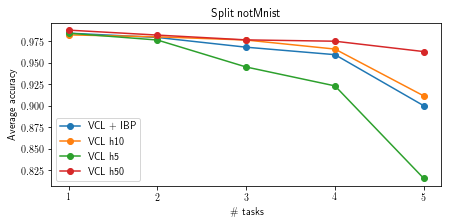

In [63]:
_ibp_acc = np.nanmean(ibp_acc, 1)
_vcl_result_h10 = np.nanmean(vcl_result, 1)
_vcl_result_h5 = np.nanmean(vcl_result_h5, 1)
_vcl_result_h50 = np.nanmean(vcl_result_h50, 1)
fig = plt.figure(figsize=(7,3))
ax = plt.gca()
plt.plot(np.arange(len(_ibp_acc))+1, _ibp_acc, label='VCL + IBP', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h10, label='VCL h10', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h5, label='VCL h5', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h50, label='VCL h50', marker='o')
ax.set_xticks(range(1, len(_ibp_acc)+1))
ax.set_ylabel('Average accuracy')
ax.set_xlabel('\# tasks')
ax.set_title('Split notMnist')
ax.legend()
fig.show()

In [64]:
with open('results/not_mnist.pkl', 'wb') as input_file:
    pickle.dump({'vcl_ibp': ibp_acc,
                 'vcl_h10': vcl_result,
                 'vcl_h5': vcl_result_h5,
                 'vcl_h50': vcl_result_h50}, input_file)